In [45]:
# import necessary libraries including the drive library to load the model in google colab
from IPython.display import display
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the model , tokenizer, and the max sequence length

In [39]:

# Path to the model file,
model_path = '/content/drive/My Drive/bilstm_model.h5'

# Loading the model
model = load_model(model_path)

# load the tokenizer and the max_seq_length
with open('/content/drive/My Drive/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
with open('/content/drive/My Drive/max_seq_length.pkl', 'rb') as f:
    max_seq_length = pickle.load(f)

## Preprocessing

In [40]:
# Function to load and preprocess text data from a CSV file
def load_and_preprocess_data(filepath):
    # Read data from CSV file at 'filepath' into a DataFrame
    data = pd.read_csv(filepath)
    # Combine 'Claim' and 'Evidence' columns into a single string per row for processing
    texts = data['Claim'] + " " + data['Evidence']
    # Extract labels for supervised learning
    labels = data['label']
    return texts, labels

## Evaluation
This function involves generating prediction for the validation dataset. It returns the actual labels and predicted labels for other functions that test the performance of the model

In [41]:
def evaluate(path):
    # Load and preprocess test data in a similar fashion as training data
    val_texts,val_labels = load_and_preprocess_data(path)
    val_sequences = tokenizer.texts_to_sequences(val_texts)
    val_data = pad_sequences(val_sequences, maxlen=max_seq_length)
    val_labels = np.array(val_labels)
    # Generate predictions for the validation set
    val_predictions = model.predict(val_data)
    # Convert probabilities to binary labels (0 or 1) based on a 0.5 threshold
    val_predicted_labels = (val_predictions > 0.5).astype(int)

    return val_labels,val_predicted_labels,val_predictions




# path to the validation dataset
path = '/content/dev.csv'
val_labels, val_predicted_labels,val_predictions = evaluate(path)



186/186 [==============================] - 52s 277ms/step



## Performance Metrics
This part evaluates the performance of the model.It uses common metrics such as *accuracy*,precision,recall,f1 score.

The weighted error metric quantifies the overall error by applying different importance (weights) to false positives and false negatives, reflecting the varying impacts of these errors on the model's performance in specific applications. In the context of classifying text as supporting evidence for claims, prioritizing false negatives (missing supporting evidence) with a higher weight (0.7) over false positives (0.3) ensures that the metric aligns with the critical need to capture all relevant information without missing key supporting details.

In [49]:
# Custom weighted error metric
def weighted_error_metric(conf_matrix, weight_fp=0.3, weight_fn=0.7):
    tn, fp, fn, tp = conf_matrix.ravel()
    weighted_error = 1 - ((weight_fp * fp / (fp + tn)) + (weight_fn * fn / (fn + tp)))
    return weighted_error

def metrics(val_labels, val_predicted_labels, val_predictions):

    # calculating metrics
    accuracy = accuracy_score(val_labels, val_predicted_labels)
    precision = precision_score(val_labels, val_predicted_labels)
    recall = recall_score(val_labels, val_predicted_labels)
    f1 = f1_score(val_labels, val_predicted_labels)
    conf_matrix = confusion_matrix(val_labels, val_predicted_labels)
    weighted_error = weighted_error_metric(conf_matrix)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Weighted Error Metric:", weighted_error)

    # Confusion Matrix Plot
    fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues", square=True, ax=ax_cm)
    ax_cm.set_ylabel('Actual label')
    ax_cm.set_xlabel('Predicted label')
    ax_cm.set_title('Accuracy Score: {0}'.format(accuracy))

    # Precision-Recall Curve Plot
    precisions, recalls, thresholds = precision_recall_curve(val_labels, val_predictions)
    fig_prc, ax_prc = plt.subplots(figsize=(8, 5))
    ax_prc.plot(thresholds, precisions[:-1], "b--", label="Precision")
    ax_prc.plot(thresholds, recalls[:-1], "g-", label="Recall")
    ax_prc.set_xlabel("Threshold")
    ax_prc.set_ylabel("Precision/Recall")
    ax_prc.set_title("Precision-Recall Curve")
    ax_prc.legend(loc="best")
    ax_prc.grid(True)
    plt.close(fig_cm)
    plt.close(fig_prc)
    # Return figures to be displayed later
    return fig_cm, fig_prc

# Example usage:
val_labels = [1, 0, 1, 0, 1]  # example data
val_predicted_labels = [1, 0, 0, 0, 1]  # example data
val_predictions = [0.8, 0.1, 0.6, 0.2, 0.9]  # example data
fig_cm, fig_prc = metrics(val_labels, val_predicted_labels, val_predictions)




Accuracy: 0.8
Precision: 1.0
Recall: 0.6666666666666666
F1 Score: 0.8
Weighted Error Metric: 0.7666666666666667


## Confusion Matrix
The confusion matrix is highly appropriate in this scenario as it clearly visualizes the performance of the model in distinguishing between supporting and non-supporting evidence, offering a straightforward breakdown of true positives, false positives, true negatives, and false negatives, which helps in assessing the model’s ability to accurately identify and classify each type of evidence.

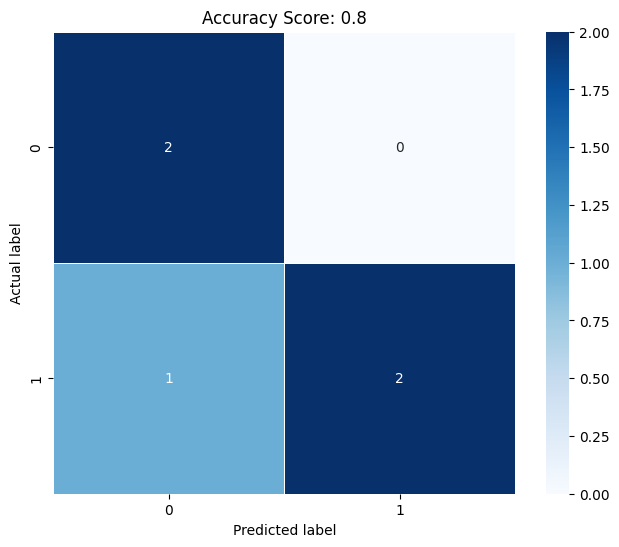

In [48]:
display(fig_cm)

## Precision Recall Curve
The precision-recall curve shows the trade-off between precision (the accuracy of positive predictions) and recall (the ability to find all positive instances) for different probability thresholds.


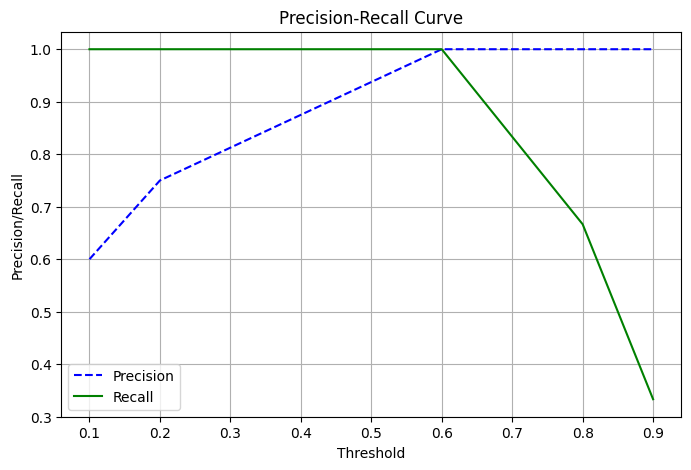

In [47]:
display(fig_prc)